In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [3]:
!ls

gdrive	sample_data


In [4]:
cd gdrive/

/content/gdrive


In [5]:
!ls

'My Drive'


In [6]:
cd My\ Drive

/content/gdrive/My Drive


In [7]:
ls

'Colab Notebooks'/           'Project proposal.gdoc'
'CT Imaging.gdoc'             Titan_spreadsheet.gsheet
 CV.pdf                      'training_signs (1).csv'
 Endoscopy.gdoc               training_signs.csv
'Fluoroscopy (1).gdoc'        Ultrasound.gdoc
 Fluoroscopy.gdoc            'Untitled Diagram (1).html'
 model.h5                    'Untitled Diagram.html'
 model.json                  'Untitled document.gdoc'
'Project proposal (1).gdoc'   X-Ray.gdoc


In [8]:
cd Colab\ Notebooks

/content/gdrive/My Drive/Colab Notebooks


In [20]:
ls

IDC_regular_ps50_idx5.zip  training_signs.csv  Untitled3.ipynb  Untitled7.ipynb
my_model2.h5               Untitled0.ipynb     Untitled4.ipynb
my_model2.json             Untitled1.ipynb     Untitled5.ipynb
testset.csv                Untitled2.ipynb     Untitled6.ipynb


In [0]:
import zipfile

fh = open('IDC_regular_ps50_idx5.zip', 'rb')
z = zipfile.ZipFile(fh)
for name in z.namelist():
    outpath = "IDC_regular_ps50_idx5/"
    z.extract(name, outpath)
fh.close()

In [22]:
ls

IDC_regular_ps50_idx5/     testset.csv         Untitled2.ipynb  Untitled6.ipynb
IDC_regular_ps50_idx5.zip  training_signs.csv  Untitled3.ipynb  Untitled7.ipynb
my_model2.h5               Untitled0.ipynb     Untitled4.ipynb
my_model2.json             Untitled1.ipynb     Untitled5.ipynb


In [23]:
len(os.listdir("IDC_regular_ps50_idx5/"))

279

In [0]:
from glob import glob
import fnmatch
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
imagePatches = glob('IDC_regular_ps50_idx5/**/*.png', recursive=True)

In [26]:
len(imagePatches)

277524

In [0]:
patternZero = '*class0.png'
patternOne = '*class1.png'
classZero = fnmatch.filter(imagePatches, patternZero) #saves the file location of all images with file name class0
classOne = fnmatch.filter(imagePatches, patternOne) #saves the file location of all images with file name class1

In [0]:
def process_images(lowerIndex,upperIndex):
    """
    Returns two arrays: 
        x is an array of resized images
        y is an array of labels
    """ 
    height = 50
    width = 50
    channels = 3
    x = [] #list to store image data
    y = [] #list to store corresponding class
    for img in imagePatches[lowerIndex:upperIndex]:
        full_size_image = cv2.imread(img)
        image = (cv2.resize(full_size_image, (width,height), interpolation=cv2.INTER_CUBIC))
        x.append(image)
        if img in classZero:
            y.append(0)
        elif img in classOne:
            y.append(1)
        else:
            return
    return x,y

In [0]:
X, Y = process_images(0,60000)

In [0]:
X = np.array(X)

In [0]:
X = X.astype(np.float32) #Casting the array to single precision takes half as much space

In [0]:
X /= 255. #Normalizing, which helps train the model faster and prevents the vanishing/ exploding gradient problem

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.2)

In [34]:
Y.count(0) #Checking the number of 0's in the array Y (this denotes number of malignant cases)

44478

In [35]:
Y.count(1) #Checking the number of 1's in the array Y (this denotes number of malignant cases)

15522

In [36]:
y_train.count(1) #Checking the number of 1's in the array y_train

12469

In [37]:
y_train.count(0) #Checking the number of 1's in the array y_train

35531

In [38]:
import keras
from keras.utils import to_categorical

Using TensorFlow backend.


In [0]:
#One-Hot-Encode y_train and y_test
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [0]:
X_trainShape = X_train.shape[1]*X_train.shape[2]*X_train.shape[3]
X_testShape = X_test.shape[1]*X_test.shape[2]*X_test.shape[3]
X_trainFlat = X_train.reshape(X_train.shape[0], X_trainShape)
X_testFlat = X_test.reshape(X_test.shape[0], X_testShape)

In [0]:
from imblearn.under_sampling import RandomUnderSampler
random_under_sampler = RandomUnderSampler(ratio='majority')
X_trainRus, Y_trainRus = random_under_sampler.fit_sample(X_trainFlat, y_train)
X_testRus, Y_testRus = random_under_sampler.fit_sample(X_testFlat, y_test)

In [0]:
# One-hot-encoding
Y_trainRusHot = to_categorical(Y_trainRus, num_classes = 2)
Y_testRusHot = to_categorical(Y_testRus, num_classes = 2)

In [43]:
np.unique(Y_trainRus, return_counts=True) #checking the number of samples in each class to make sure RandomUnderSampling worked

(array([0, 1]), array([12469, 12469]))

In [0]:
for i in range(len(X_trainRus)):
    height, width, channels = 50,50,3
    X_trainRusReshaped = X_trainRus.reshape(len(X_trainRus),height,width,channels)

In [0]:
for i in range(len(X_testRus)):
    height, width, channels = 50,50,3
    X_testRusReshaped = X_testRus.reshape(len(X_testRus),height,width,channels)

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator

In [0]:
batch_size = 256
num_classes = 2
epochs = 80

In [48]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3,3),
                 activation='relu',
                 input_shape=(50,50,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(Flatten()) #this converts our 3D feature maps to 1D feature vectors for the dense layer below
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='sigmoid'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adam(lr=0.00001),
              metrics=['accuracy'])

In [0]:
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=180,
    horizontal_flip=True,vertical_flip = True)

In [0]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping_monitor = EarlyStopping(monitor='val_loss', patience=3, mode='min')
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [52]:
training = model.fit_generator(datagen.flow(X_trainRusReshaped,Y_trainRusHot,batch_size=batch_size),
                    steps_per_epoch=len(X_trainRusReshaped) / batch_size, epochs=epochs,validation_data=(X_testRusReshaped, Y_testRusHot), verbose=1, callbacks=[early_stopping_monitor, model_checkpoint])

Instructions for updating:
Use tf.cast instead.
Epoch 1/80


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


98/97 [==============================] - 20s 207ms/step - loss: 0.6897 - acc: 0.5060 - val_loss: 0.6848 - val_acc: 0.4997

Epoch 00001: val_loss improved from inf to 0.68480, saving model to best_model.h5
Epoch 2/80
98/97 [==============================] - 15s 153ms/step - loss: 0.6729 - acc: 0.5785 - val_loss: 0.6312 - val_acc: 0.7232

Epoch 00002: val_loss improved from 0.68480 to 0.63121, saving model to best_model.h5
Epoch 3/80
98/97 [==============================] - 15s 158ms/step - loss: 0.5976 - acc: 0.7261 - val_loss: 0.5262 - val_acc: 0.7614

Epoch 00003: val_loss improved from 0.63121 to 0.52617, saving model to best_model.h5
Epoch 4/80
98/97 [==============================] - 18s 183ms/step - loss: 0.5227 - acc: 0.7658 - val_loss: 0.5113 - val_acc: 0.7638

Epoch 00004: val_loss improved from 0.52617 to 0.51130, saving model to best_model.h5
Epoch 5/80
98/97 [==============================] - 16s 159ms/step - loss: 0.4961 - acc: 0.7771 - val_loss: 0.4871 - val_acc: 0.7806

E

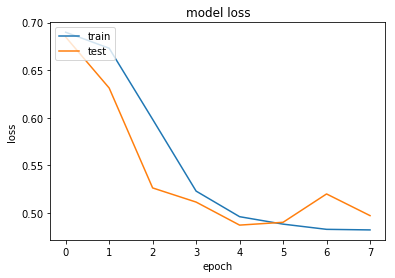

In [53]:
plt.plot(training.history['loss'])
plt.plot(training.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [54]:
from keras.models import load_model
from sklearn import metrics
model = load_model('best_model.h5')

y_pred_one_hot = model.predict(X_testRusReshaped)
y_pred_labels = np.argmax(y_pred_one_hot, axis = 1)

y_true_labels = np.argmax(Y_testRusHot,axis=1)

confusion_matrix = metrics.confusion_matrix(y_true=y_true_labels, y_pred=y_pred_labels)
print(confusion_matrix)

[[2395  658]
 [ 681 2372]]
